In [1]:

import numpy as np
import pydicom
import os
import sys
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

print(tf.__version__)
print(keras.__version__)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
import warnings
warnings.filterwarnings(action='once')
import cv2


2.8.1
2.8.0
Num GPUs Available:  0


2022-11-07 18:25:25.042751: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-07 18:25:25.042800: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: mim-1-3
2022-11-07 18:25:25.042828: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: mim-1-3
2022-11-07 18:25:25.043002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 495.29.5
2022-11-07 18:25:25.043159: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 495.29.5
2022-11-07 18:25:25.043173: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 495.29.5


In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
from keras import layers
np.random.seed(1)
random.seed(2)
tf.random.set_seed(3)

EPOCHS = 9
MODEL_DIR = '/home/shared/model_checkpoint_paige/singlescan-3channel/'

CROPPED = 0
MASKED = 1
ORIGINAL = 2

IMG_TYPE = 0
IMAGE_PATH = '/home/shared/nps/imgs/'
BATCH_SIZE = 16

FOLDS=10

In [2]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids = all_ids[all_ids.contains_lung == True].sample(frac=1).reset_index(drop=True)
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')

/tmp/ipykernel_3931414/1656503385.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_ids = pd.read_csv('all_ids_updated.csv')


In [22]:
# study_ids = all_ids.pivot_table(index='StudyInstanceUID').sort_values('pe_present_on_image').index

# fold_df = pd.DataFrame({'StudyInstanceUID': all_ids.StudyInstanceUID.unique()})
# fold_df['fold'] = False 
# for fold in range(FOLDS): 
#     fold_ids = [study_ids[i] for i in range(len(study_ids)) if i%FOLDS == fold]
#     fold_df.loc[fold_df.StudyInstanceUID.isin(fold_ids), 'fold'] = int(fold)

# fold_df.to_csv('folds.csv', index=False)

In [6]:
# fold_df

In [13]:
all_ids.ycoord = all_ids.ycoord.astype('float')

SLAB_SIZE = 3

all_ids_slab = all_ids.sort_values(['StudyInstanceUID', 'ycoord'])
all_ids_slab['endStudyUID'] = all_ids_slab.StudyInstanceUID.shift(SLAB_SIZE - 1)

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_present_on_image
for i in range(1, SLAB_SIZE):
    all_ids_slab['pe_' + str(i)] = all_ids_slab.pe_present_on_image.shift(i)
    all_ids_slab['SOP_' + str(i)] = all_ids_slab.SOPInstanceUID.shift(i)
    all_ids_slab['pe_in_slab'] = all_ids_slab['pe_in_slab'] + all_ids_slab['pe_' + str(i)]

all_ids_slab['pe_in_slab'] = all_ids_slab.pe_1 == 1

all_ids_slab = all_ids_slab[all_ids_slab.StudyInstanceUID == all_ids_slab.endStudyUID]

all_ids_slab = all_ids_slab.reset_index(drop=True)

In [14]:
fold_df = pd.read_csv('folds.csv')
all_ids_slab = pd.merge(all_ids_slab, fold_df)

In [15]:
def get_model() -> keras.models.Model:
    
    from keras_cv_attention_models import coatnet

    inputs = keras.Input(shape=(256,256,3))
    
    coat = coatnet.CoAtNet0(pretrained='imagenet', num_classes=512, classifier_activation='relu', input_shape=(256,256,3), drop_connect_rate = 0.03)

    x = coat(inputs)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(64)(x)
    x = keras.layers.Dropout(0.8)(x)
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.models.Model(inputs=inputs, outputs=output)
    return model

# def get_model_orig(num_channels: int) -> keras.models.Model:
    
#     from keras_cv_attention_models import coatnet
    
#     inputs = keras.Input(shape=(256,256,3))
    
#     coat = coatnet.CoAtNet0(pretrained='imagenet', num_classes=512, classifier_activation='relu', input_shape=(256,256,3))

#     x = coat(inputs)
#     x = keras.layers.Dropout(0.2)(x)
#     x = keras.layers.Dense(64)(x)
#     x = keras.layers.Dropout(0.8)(x)
#     output = keras.layers.Dense(1, activation="sigmoid")(x)
#     model = keras.models.Model(inputs=inputs, outputs=output)
#     return model


def get_generators(
    all_df,
    fold: int,
    img_type,
    batch_size
):
    
    train_df = all_df[all_df.fold != fold]
    test_df = all_df[all_df.fold == fold]
    
    train_generator = DataSlabGenerator(train_df, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   n_channels=3, 
                                   set_type='train',
                                   batch_size=batch_size,
                                   shuffle=True)
    
    valid_generator = DataSlabGenerator(test_df, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   set_type = 'valid',
                                   n_channels=3, 
                                   batch_size=batch_size,
                                   shuffle=False)
    
    test_generator = DataSlabGenerator(test_df, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   set_type = 'test',
                                   n_channels=3, 
                                   batch_size=batch_size,
                                   shuffle=False)
    
    return train_generator, valid_generator, test_generator

def train(all_df, model_name, fold):
    model = get_model()

    train_generator, valid_generator, test_generator = get_generators(all_df, fold, CROPPED, BATCH_SIZE)

    opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)

    checkpoint_path = os.path.join(MODEL_DIR, f"{model_name}_fold_{fold:02d}.h5")
    training_histories = []

    check = keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        save_best_only=True,
        verbose=1,
    )

    model.compile(loss="binary_crossentropy", 
                  optimizer=opt, 
                  metrics=["accuracy"])

    print(model.summary())
    
    hist_full = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=valid_generator,
        callbacks=[check],
    )

    training_histories.append(pd.DataFrame(hist_full.history))
    
    hist_test = model.evaluate(test_generator)
    
    training_histories.append(pd.DataFrame(hist_test.history))

    df_hist = pd.concat(training_histories, axis=0, ignore_index=True, sort=False)
    df_hist.to_csv(os.path.join(MODEL_DIR, f"hist_{model_prefix}_fold_{fold:02d}.csv"))

In [16]:
import turku_aug_funcs

class DataSlabGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, all_df, image_path, img_type, set_type, n_channels=1, 
                 batch_size=32, dim=256, num_pos=None, n_classes=2, shuffle=True,
                 verbose=False, to_fit=True,
                 ):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.image_path = image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.path_dicom = image_path
        self.verbose = verbose
        self.img_type = img_type
        warnings.filterwarnings(action='ignore')
        self.all_df = all_df
        self.set_type = set_type
                
        self.labels = all_df
        self.list_IDs = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)

    def get_df(self):
        return self.all_df
        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size,self.dim,self.dim,3])
        y = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            X[i], y[i] = self._load_dicom(indexes[i])
            
        if self.verbose == True:
            fig, ax = plt.subplots(self.batch_size, 1, figsize=[12, 12*(self.batch_size/2)])
            for i in range(self.batch_size):
                ax[i].imshow(X[i])
                ax[i].axis('off')
        
        X = X/255
        if self.to_fit:
            return (X, y)
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.set_type == 'train':
            sample_set = self.all_df[self.all_df.fold != self.fold]
            sample_set = sample_set.reset_index(drop=True)
            pos = sample_set[sample_set.pe_in_slab ==True]
            neg = sample_set[sample_set.pe_in_slab == False].sample(n=len(pos)*3)
            self.labels = pd.concat([pos,pos,pos,neg]).sample(frac=1).reset_index(drop=True)
            
        self.list_IDs = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)

    def _load_dicom(self, index):
        slice = self.labels.iloc[index] 

        frames = np.zeros((self.dim,self.dim,3))
        frame = cv2.imread(self.image_path+slice.StudyInstanceUID + '_'+ slice.SeriesInstanceUID
                      + '_' + slice.SOPInstanceUID +'.png')
        frame = frame[:,:,self.img_type]
        frames[:,:,0] = frame

        frame = cv2.imread(self.image_path+slice.StudyInstanceUID + '_'+ slice.SeriesInstanceUID
                      + '_' + slice.SOP_1 +'.png')
        frame = frame[:,:,self.img_type]
        frames[:,:,1] = frame    

        frame = cv2.imread(self.image_path+slice.StudyInstanceUID + '_'+ slice.SeriesInstanceUID
                      + '_' + slice.SOP_2 +'.png')
        frame = frame[:,:,self.img_type]
        frames[:,:,2] = frame       
                
        if False:
#         self.set_type == 'train':
            trans = random.sample(range(0,4),random.randint(0,4))

            if 0 in trans:
                frames = turku_aug_funcs.blur(frames)

            if 1 in trans:
                zoom = random.randint(0,2)
                if zoom == 0:
                    frames = turku_aug_funcs.zoom_1_05(frames)
                if zoom == 1:
                    frames = turku_aug_funcs.zoom_1_075(frames)
                if zoom == 2:
                    frames = turku_aug_funcs.zoom_1_15(frames)
            if 2 in trans:
                rot = random.randint(0,3)
                if rot == 0:
                    frames = turku_aug_funcs.rotate_3(frames)
                if rot == 1:
                    frames = turku_aug_funcs.rotate_m3(frames)
                if rot == 2:
                    frames = turku_aug_funcs.rotate_5(frames)
                if rot == 3:
                    frames = turku_aug_funcs.rotate_m5(frames)

            if 3 in trans:
                tx = random.randint(0,6)
                if tx == 0:
                    frames = turku_aug_funcs.tr_x10(frames)
                if tx == 1:
                    frames = turku_aug_funcs.tr_x15(frames)
                if tx == 2:
                    frames = turku_aug_funcs.tr_x20(frames)
                if tx == 3:
                    frames = turku_aug_funcs.tr_xm10(frames)
                if tx == 4:
                    frames = turku_aug_funcs.tr_xm15(frames)
                if tx == 5:
                    frames = turku_aug_funcs.tr_xm20(frames)
                tx = random.randint(0,6)
                if tx == 0:
                    frames = turku_aug_funcs.tr_y10(frames)
                if tx == 1:
                    frames = turku_aug_funcs.tr_y15(frames)
                if tx == 2:
                    frames = turku_aug_funcs.tr_y20(frames)
                if tx == 3:
                    frames = turku_aug_funcs.tr_ym10(frames)
                if tx == 4:
                    frames = turku_aug_funcs.tr_ym15(frames)
                if tx == 5:
                    frames = turku_aug_funcs.tr_ym20(frames)
                        
        frames = np.reshape(frames, (256,256,3))
        
        if self.verbose == True:
            print(np.shape(frames))
            plt.imshow(frames[:,:,0])
            plt.show()

        frames = frames[None, ...]
        y = np.array([int(slice.pe_in_slab)])
        y = y[None, ...]
        
        return frames, y

/home/jupyter-paige/turku_aug_funcs.py:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/home/jupyter-paige/turku_aug_funcs.py:4: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


In [17]:
import turku_aug_funcs

class DataSliceGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, all_df, image_path, img_type, set_type, n_channels=1, 
                 batch_size=32, dim=386, num_pos=None, n_classes=2, shuffle=True,
                 verbose=False, to_fit=True,
                 ):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        :param mask_path: path to masks location
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_channels: number of image channels
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.image_path = image_path
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.path_dicom = image_path
        self.verbose = verbose
        self.img_type = img_type
        warnings.filterwarnings(action='ignore')
        self.all_df = all_df
        self.set_type = set_type

        if self.set_type == 'test':
            self.labels = self.all_df
        elif self.set_type == 'valid':
            pos = self.all_df[self.all_df.pe_present_on_image == True]
            neg = self.all_df[self.all_df.pe_present_on_image == False].sample(n=len(pos))
            self.labels = pd.concat([pos,neg]).sample(frac=1).reset_index(drop=True)
        elif self.set_type == 'train':
            pos = self.all_df[self.all_df.pe_present_on_image ==True]
            neg = self.all_df[self.all_df.pe_present_on_image == False].sample(n=len(pos)*3)
            self.labels = pd.concat([pos,pos,pos,neg]).sample(frac=1).reset_index(drop=True)
        else:
            print('Invalid set type, must be test, valid or train')
            return False
        
        self.list_IDs = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)

        
    def get_df(self):
        return self.labels

        
    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        
        indexes = self.list_IDs[index * self.batch_size:((index+1) * self.batch_size)]
        X = np.zeros([self.batch_size,self.dim,self.dim,1])
        y = np.zeros([self.batch_size, 1])
        for i in range(0,self.batch_size):
            X[i], y[i] = self._load_dicom(indexes[i])
            
        if self.verbose == True:
            fig, ax = plt.subplots(self.batch_size, 1, figsize=[12, 12*(self.batch_size/2)])
            for i in range(self.batch_size):
                ax[i].imshow(X[i])
                ax[i].axis('off')
        
        X = X/255
            
        if self.to_fit:
            return (X, y)
        else:
            return (X)
        
    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        if self.set_type == 'train':
            pos = self.all_df[self.all_df.pe_present_on_image ==True]
            neg = self.all_df[self.all_df.pe_present_on_image == False].sample(n=len(pos)*3)
            self.labels = pd.concat([pos,pos,pos,neg]).sample(frac=1).reset_index(drop=True)
            
        self.list_IDs = np.arange(len(self.labels))
        if self.shuffle == True:
            np.random.shuffle(self.list_IDs)

            
    def _load_dicom(self, index):
        slice = self.labels.iloc[index] 

        frame = cv2.imread(self.image_path+slice.StudyInstanceUID + '_'+ slice.SeriesInstanceUID
                      + '_' + slice.SOPInstanceUID +'.png')
        frame = frame[:,:,self.img_type]
        
#         frame = np.reshape(frame, (256,256,1))      
        
        if self.set_type == 'train':
            trans = random.sample(range(0,5),random.randint(0,5))
            if 0 in trans:
                frame = turku_aug_funcs.blur(frame)
            if 1 in trans:
                zoom = random.randint(0,2)
                if zoom == 0:
                    frame = turku_aug_funcs.zoom_1_05(frame)
                if zoom == 1:
                    frame = turku_aug_funcs.zoom_1_075(frame)
                if zoom == 2:
                    frame = turku_aug_funcs.zoom_1_15(frame)

            if 2 in trans:
                rot = random.randint(0,3)
                if rot == 0:
                    frame = turku_aug_funcs.rotate_3(frame)
                if rot == 1:
                    frame = turku_aug_funcs.rotate_m3(frame)
                if rot == 2:
                    frame = turku_aug_funcs.rotate_5(frame)
                if rot == 3:
                    frame = turku_aug_funcs.rotate_m5(frame)

            if 3 in trans:
                frame = np.reshape(frame, (1,256,256))
                frame = turku_aug_funcs.gaussian_noise(frame)
                frame = frame.squeeze()

            if 4 in trans:
                tx = random.randint(0,6)
                if tx == 0:
                    frame = turku_aug_funcs.tr_x10(frame)
                if tx == 1:
                    frame = turku_aug_funcs.tr_x15(frame)
                if tx == 2:
                    frame = turku_aug_funcs.tr_x20(frame)
                if tx == 3:
                    frame = turku_aug_funcs.tr_xm10(frame)
                if tx == 4:
                    frame = turku_aug_funcs.tr_xm15(frame)
                if tx == 5:
                    frame = turku_aug_funcs.tr_xm20(frame)
                tx = random.randint(0,6)
                if tx == 0:
                    frame = turku_aug_funcs.tr_y10(frame)
                if tx == 1:
                    frame = turku_aug_funcs.tr_y15(frame)
                if tx == 2:
                    frame = turku_aug_funcs.tr_y20(frame)
                if tx == 3:
                    frame = turku_aug_funcs.tr_ym10(frame)
                if tx == 4:
                    frame = turku_aug_funcs.tr_ym15(frame)
                if tx == 5:
                    frame = turku_aug_funcs.tr_ym20(frame)
        frame = cv2.resize(frame, (386,386))
        frame = np.reshape(frame, (386,386,1))
        
        if self.verbose == True:
            print(np.shape(frame))
            plt.imshow(frame)
            plt.show()

        frame = frame[None, ...]
        y = np.array([int(slice.pe_present_on_image)])
        y = y[None, ...]
        
        return frame, y

CROPPED = 0
MASKED = 1
ORIGINAL = 2

IMG_TYPE = MASKED
IMAGE_PATH = '/home/shared/nps/imgs/'

def get_turku_model(num_channels: int) -> keras.models.Model:
    
    inputs = keras.Input(shape=(386,386,1))
    
    inception = InceptionResNetV2Gray(
                    input_shape=(IMAGE_H, IMAGE_W, 1),
                    include_top=False,
                    weights='pretrained/InceptionResNetV2_NIH15_Px256.h5',
                )
    x = inception(inputs)
    x = keras.layers.GlobalAveragePooling2D()(inception.output)
    x = keras.layers.Dense(512, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(ENCODING_DIM)(x)
    x = keras.layers.Dense(1, activation="sigmoid")(x)
    model = keras.models.Model(inputs=inception.input, outputs=x)
    return model


def get_turku_generators(
    df,
    fold,
):

    train_df = df[df.fold != fold].reset_index(drop=True)
    test_df = df[df.fold == fold].reset_index(drop=True)

    
    train_generator = DataSliceGenerator(train_df, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   n_channels=1, 
                                   set_type='train',
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   dim=386)
    
    valid_generator = DataSliceGenerator(test_df, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   set_type = 'valid',
                                   n_channels=1, 
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   dim=386)

    test_generator = DataSliceGenerator(test_df, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   set_type = 'test',
                                   n_channels=1, 
                                   batch_size=BATCH_SIZE,
                                   shuffle=False,
                                   dim=386)
    
    return train_generator, valid_generator, test_generator

In [18]:
all_ids_slab = all_ids_slab.sample(frac=1).reset_index(drop=True)

In [12]:
BATCH_SIZE =1 
fold = 1
train_generator, valid_generator, test_generator = get_generators(all_ids_slab, fold, CROPPED, 1)

x_test_1 = np.zeros([4000,256,256,3])
y_test_1 = np.zeros([4000,1])
for j in range(0,4000):
    x_test_1[j],y_test_1[j]= test_generator.__getitem__(j)

1 train [9 2 0 8 5 3 7 6 4]
1 valid [1]
1 test [1]


In [13]:
BATCH_SIZE =1 
fold = 0
train_generator, valid_generator, test_generator = get_generators(all_ids_slab, fold, CROPPED, 1)

x_test_0 = np.zeros([8000,256,256,3])
y_test_0 = np.zeros([8000,1])
for j in range(0,8000):
    x_test_0[j],y_test_0[j]= test_generator.__getitem__(j)

0 train [7 2 4 8 1 6 9 5 3]
0 valid [0]
0 test [0]



KeyboardInterrupt



In [ ]:
BATCH_SIZE =1 
fold = 0
train_generator, valid_generator, test_generator = get_turku_generators(all_ids_slab, fold, CROPPED, 1)

x_test_0_t = np.zeros([8000,386,386,1])
y_test_0_t = np.zeros([8000,1])
for j in range(0,8000):
    x_test_0_t[j],y_test_0_t[j]= test_generator.__getitem__(j)

In [42]:
BATCH_SIZE =1 
fold = 1
train_generator, valid_generator, test_generator = get_turku_generators(all_ids_slab, fold )

x_test_1_t = np.zeros([4000,386,386,1])
y_test_1_t = np.zeros([4000,1])
for j in range(0,4000):
    x_test_1_t[j],y_test_1_t[j]= test_generator.__getitem__(j)

In [65]:
BATCH_SIZE =64
fold = 4
train_generator, valid_generator, test_generator = get_generators(all_ids_slab, fold, CROPPED, BATCH_SIZE)

0 train [3 2 5 9 6 1 4 8 7]
0 valid [0]
0 test [0]


In [89]:
len(test_fold_0[(test_fold_0.pe_in_slab == False)]) - test_fold_0[(test_fold_0.pe_in_slab == False)].pred_round.sum(),  test_fold_0[(test_fold_0.pe_in_slab == False)].pred_round.sum()

(108282, 92939.0, 15343.0)

In [ ]:
[[len(test_fold_0[(test_fold_0.pe_in_slab == True)]) - test_fold_0[(test_fold_0.pe_in_slab == True)].pred_round.sum(), test_fold_0[(test_fold_0.pe_in_slab == True)].pred_round.sum()],
[len(test_fold_0[(test_fold_0.pe_in_slab == False)]) - test_fold_0[(test_fold_0.pe_in_slab == False)].pred_round.sum(),  test_fold_0[(test_fold_0.pe_in_slab == False)].pred_round.sum()]]

In [20]:
cm = [[1504, 6956],[92939, 15343]]

In [25]:
sensitivity = cm[0][1]/np.sum(cm[0])
specificity = cm[1][0]/np.sum(cm[1])
npv = cm[1][0]/(cm[0][0] + cm[1][0])
ppv = cm[0][1]/(cm[0][1] + cm[1][1])

In [1]:
(82.2+85.8)/2

84.0

In [26]:
sensitivity, specificity, npv, ppv

(0.8222222222222222,
 0.8583051661402634,
 0.9840750505595968,
 0.3119422395623122)

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def test_version(model, weights, x_test, y_test):
    model.load_weights(weights)
    y_pred_tot = np.zeros(np.shape(y_test))
    for i in range(int(len(x_test)/8)):
        y_pred_tot[i*8:(i+1)*8] = model.predict_on_batch(x_test[i*8:(i+1)*8])
        if i % 100 == 0:
            print(i)
    cm = confusion_matrix(y_test, y_pred_tot.round())

    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    ppv = cm[0][0]/(cm[0][0]+cm[1][0])
    npv = cm[1][1]/(cm[1][1]+cm[0][1])

    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_tot, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
#     display.plot()
    
    return cm, sensitivity, sepecifity, npv, ppv, display


In [ ]:
model = get_model()
cm, sensitivity, sepecifity, npv, ppv, display = test_version(model, 
             '/home/shared/model_checkpoint_paige/singlescan-3channel/coat-net-kfold_fold_00.h5',
            x_test_0,
            y_test_0)

 0.8841028402207565 
 0.7863397548161121 
 0.9817638266068759 
 0.3427480916030534 

[[6568  861]
 [ 122  449]]


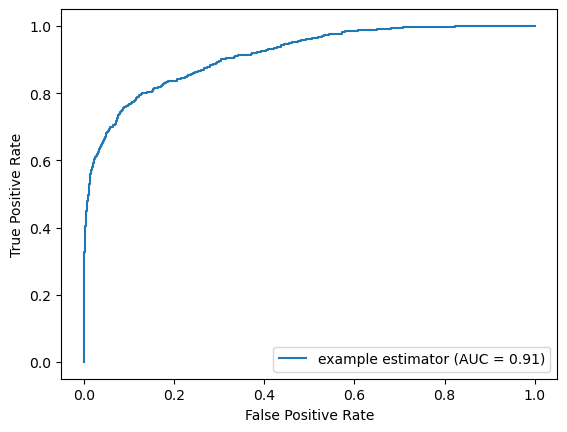

In [25]:
print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n')
print(cm)
display.plot()

 0.9057634526085769 
 0.8082595870206489 
 0.9807749186631174 
 0.44264943457189015 

[[3316  345]
 [  65  274]]


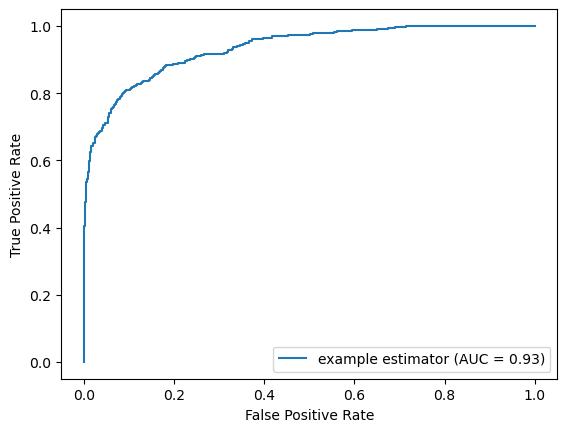

In [44]:
print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n')
print(cm)
display.plot()

In [ ]:
model = get_model()
cm, sensitivity, sepecifity, npv, ppv, display = test_version(model, 
             '/home/shared/model_checkpoint_paige/singlescan-3channel/coat-net-kfold_fold_01.h5',
            x_test_1,
            y_test_1)
print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n')
print(cm)
display.plot()

In [ ]:
from keras.applications.inception_resnet_v2 import preprocess_input
from inception_resnet_v2_gray import InceptionResNetV2Gray
IMAGE_H = IMAGE_W = 386
ENCODING_DIM = 64

model = get_turku_model(1)
cm, sensitivity, sepecifity, npv, ppv, display  = test_version(model, 
             '/home/shared/model_checkpoint_paige/singlescan-3channel/turku-incepres_fold_01.h5',
            x_test_1_t,
            y_test_1_t)

 0.8699690402476781 
 0.8056042031523643 
 0.9831153027076361 
 0.3225806451612903 

[[6463  966]
 [ 111  460]]


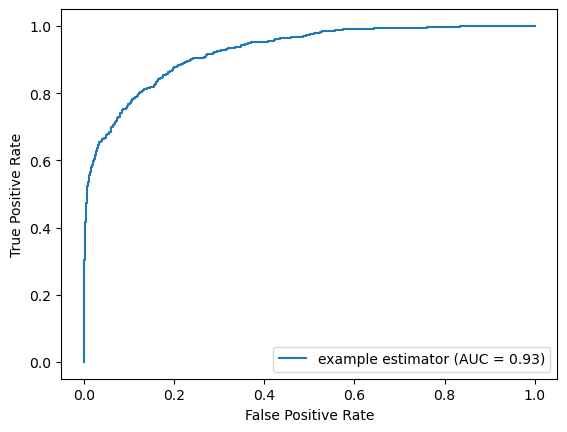

In [33]:
print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n')
print(cm)
display.plot()

In [ ]:
import gc
gc.collect()

In [11]:
all_ids = pd.read_csv('all_ids_updated.csv')
all_ids = all_ids[all_ids.contains_lung == True].sample(frac=1).reset_index(drop=True)
all_ids.ycoord = all_ids.ycoord.replace('True', '1.0').astype('float')

all_ids_small = all_ids.drop(columns=['negative_exam_for_pe', 'qa_motion',
       'qa_contrast', 'flow_artifact', 'rv_lv_ratio_gte_1', 'rv_lv_ratio_lt_1',
       'leftsided_pe', 'chronic_pe', 'true_filling_defect_not_pe',
       'rightsided_pe', 'acute_and_chronic_pe', 'central_pe', 'indeterminate',
       'contains_lung'])

In [16]:
model = get_model(3)
model.load_weights('/home/shared/model_checkpoint_paige/singlescan-3channel/coat-net-kfold_fold_02.h5')
# model_partial = keras.models.Sequential(model.layers[:-2])
model_partial = keras.models.Model(inputs=model.input, outputs=[model.layers[-2].output])
model_partial.summary()

>>>> Load pretrained from: /home/jupyter-paige/.keras/models/coatnet0_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (256, 256)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 coatnet0 (Functional)       (None, 512)               22930490  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                 

In [10]:
import datetime
import gc

In [80]:
fold = 1
IMAGE_PATH = '/home/shared/nps/imgs/'

test_set = all_ids_slab[all_ids_slab.fold == fold]
test_set = test_set.reset_index(drop=True)
_, _, test_generator = get_generators(all_ids_slab, fold, CROPPED, 1)

b_size = 32
model = get_model()
model.load_weights('/home/shared/model_checkpoint_paige/singlescan-3channel/coat-net-kfold_fold_0'+str(fold)+'.h5')

preds = np.zeros((len(test_set),1))

scans = np.zeros((b_size,256,256,3))
for i in range(0, len(test_set)):
    scan, _ = test_generator.__getitem__(i)
    
    scans[i%b_size] = scan
    
    if i%b_size == b_size-1:
        preds[i-(b_size-1):i+1] = model.predict_on_batch(scans)
        
    if i == len(test_set) -1:
        preds[i - i%b_size:] = model.predict_on_batch(scans[:i%b_size+1])

    if i %400 == 0:
        print(i, 'time is: ', datetime.datetime.now())
        gc.collect()
        
test_set['preds'] = preds
test_set.to_csv('test_fold_' + str(fold) +'.csv')

1 train [2 8 4 5 7 0 6 9 3]
1 valid [1]
1 test [1]
>>>> Load pretrained from: /home/jupyter-paige/.keras/models/coatnet0_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (256, 256)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb
0 time is:  2022-10-31 16:38:19.434135
400 time is:  2022-10-31 16:38:32.723917
800 time is:  2022-10-31 16:38:43.054463
1200 time is:  2022-10-31 16:38:51.967121
1600 time is:  2022-10-31 16:39:01.323635
2000 time is:  2022-10-31 16:39:10.918408
2400 time is:  2022-10-31 16:39:21.249110
2800 time is:  2022-10-31 16:39:30.961675
3200 time is:  2022-10-31 16:39:40.900555
3600 time is:  2022-10-31 16:39:50.311369
4000 time is:  2022-10-31 16:40:00.977859
4400 time is:  2022-

51200 time is:  2022-10-31 16:59:32.414640
51600 time is:  2022-10-31 16:59:41.527516
52000 time is:  2022-10-31 16:59:51.368826
52400 time is:  2022-10-31 17:00:01.034160
52800 time is:  2022-10-31 17:00:10.283860
53200 time is:  2022-10-31 17:00:19.801800
53600 time is:  2022-10-31 17:00:29.854722
54000 time is:  2022-10-31 17:00:39.465089
54400 time is:  2022-10-31 17:00:49.734965
54800 time is:  2022-10-31 17:00:59.462279
55200 time is:  2022-10-31 17:01:09.043203
55600 time is:  2022-10-31 17:01:18.214895
56000 time is:  2022-10-31 17:01:28.305504
56400 time is:  2022-10-31 17:01:38.182993
56800 time is:  2022-10-31 17:01:47.777789
57200 time is:  2022-10-31 17:01:57.678795
57600 time is:  2022-10-31 17:02:07.622167
58000 time is:  2022-10-31 17:02:16.724908
58400 time is:  2022-10-31 17:02:26.022905
58800 time is:  2022-10-31 17:02:35.402725
59200 time is:  2022-10-31 17:02:45.409299
59600 time is:  2022-10-31 17:02:54.941263
60000 time is:  2022-10-31 17:03:04.987408
60400 time 

In [81]:
from keras.applications.inception_resnet_v2 import preprocess_input
from inception_resnet_v2_gray import InceptionResNetV2Gray
IMAGE_H = IMAGE_W = 386
ENCODING_DIM = 64


# fold = 1
IMAGE_PATH = '/home/shared/nps/imgs/'
BATCH_SIZE = 1

test_set_t = all_ids_slab[all_ids_slab.fold == fold]
test_set_t = test_set_t.reset_index(drop=True)
_, _, test_generator = get_turku_generators(all_ids_slab, fold)

model = get_turku_model(1)
model.load_weights('/home/shared/model_checkpoint_paige/singlescan-3channel/turku-incepres_fold_0'+ str(fold)+ '.h5')

preds = np.zeros((len(test_set),1))

scans = np.zeros((b_size,386,386,1))
for i in range(0, len(test_set)):
    scan, _ = test_generator.__getitem__(i)
    
    scans[i%b_size] = scan
    
    if i%b_size == b_size-1:
        preds[i-(b_size-1):i+1] = model.predict_on_batch(scans)
        
    if i == len(test_set) -1:
        preds[i - i%b_size:] = model.predict_on_batch(scans[:i%b_size+1])

    if i %400 == 0:
        print(i, 'time is: ', datetime.datetime.now())
        gc.collect()
        
test_set_t['preds'] = preds
test_set_t.to_csv('turku_test_fold_'+ str(fold)+'.csv')

0 time is:  2022-10-31 17:27:29.408742
400 time is:  2022-10-31 17:27:49.532014
800 time is:  2022-10-31 17:28:00.858295
1200 time is:  2022-10-31 17:28:11.594926
1600 time is:  2022-10-31 17:28:22.534768
2000 time is:  2022-10-31 17:28:32.124888
2400 time is:  2022-10-31 17:28:43.709536
2800 time is:  2022-10-31 17:28:53.849825
3200 time is:  2022-10-31 17:29:04.137305
3600 time is:  2022-10-31 17:29:15.202030
4000 time is:  2022-10-31 17:29:26.463634
4400 time is:  2022-10-31 17:29:37.150140
4800 time is:  2022-10-31 17:29:49.023427
5200 time is:  2022-10-31 17:29:59.753089
5600 time is:  2022-10-31 17:30:11.437307
6000 time is:  2022-10-31 17:30:22.066079
6400 time is:  2022-10-31 17:30:33.125929
6800 time is:  2022-10-31 17:30:43.452532
7200 time is:  2022-10-31 17:30:54.919243
7600 time is:  2022-10-31 17:31:04.818522
8000 time is:  2022-10-31 17:31:16.458500
8400 time is:  2022-10-31 17:31:26.425173
8800 time is:  2022-10-31 17:31:37.816183
9200 time is:  2022-10-31 17:31:47.9578

76800 time is:  2022-10-31 18:01:50.968924
77200 time is:  2022-10-31 18:02:01.091441
77600 time is:  2022-10-31 18:02:12.190885
78000 time is:  2022-10-31 18:02:22.887973
78400 time is:  2022-10-31 18:02:33.685383
78800 time is:  2022-10-31 18:02:43.198685
79200 time is:  2022-10-31 18:02:53.825140
79600 time is:  2022-10-31 18:03:03.745873
80000 time is:  2022-10-31 18:03:15.447587
80400 time is:  2022-10-31 18:03:25.845390
80800 time is:  2022-10-31 18:03:36.800414
81200 time is:  2022-10-31 18:03:46.651413
81600 time is:  2022-10-31 18:03:57.713673
82000 time is:  2022-10-31 18:04:08.250780
82400 time is:  2022-10-31 18:04:18.639045
82800 time is:  2022-10-31 18:04:29.592645
83200 time is:  2022-10-31 18:04:40.302739
83600 time is:  2022-10-31 18:04:50.709887
84000 time is:  2022-10-31 18:05:02.210751
84400 time is:  2022-10-31 18:05:11.782558
84800 time is:  2022-10-31 18:05:22.540572
85200 time is:  2022-10-31 18:05:33.498529
85600 time is:  2022-10-31 18:05:44.429147
86000 time 

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def test_full_sets(y_test, y_pred):
    cm = confusion_matrix(y_test, np.round(y_pred))

    sepecifity = cm[1][1]/(cm[1][1]+cm[1][0])
    sensitivity = cm[0][0]/(cm[0][0]+cm[0][1])
    accuracy = (cm[1][1]+cm[0][0])/(cm[1][1]+cm[1][0]+cm[0][0]+cm[0][1])

    ppv = cm[0][0]/(cm[0][0]+cm[1][0])
    npv = cm[1][1]/(cm[1][1]+cm[0][1])

    print('',sensitivity,'\n',sepecifity,'\n',ppv,'\n',npv,'\n',accuracy)
    print(cm)

    from sklearn import metrics
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                      estimator_name='example estimator')
    display.plot()

In [19]:
turku_test_0 = pd.read_csv('turku_test_fold_0.csv')
turku_test_1 = pd.read_csv('turku_test_fold_1.csv')

coat_test_0 = pd.read_csv('test_fold_0.csv')
coat_test_1 = pd.read_csv('test_fold_1.csv')


 0.8696366893851241 
 0.8270685579196217 
 0.9847012935406624 
 0.3314071898830105 
 0.866551883640849
[[94166 14116]
 [ 1463  6997]]


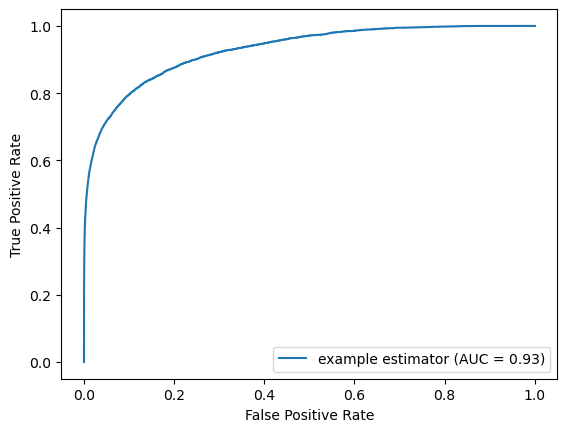

In [21]:
test_full_sets(turku_test_0.pe_in_slab, turku_test_0.preds)

 0.8831096868333318 
 0.7899775440255289 
 0.981755834129013 
 0.3455870947727625 
 0.8763598362200408
[[95624 12657]
 [ 1777  6684]]


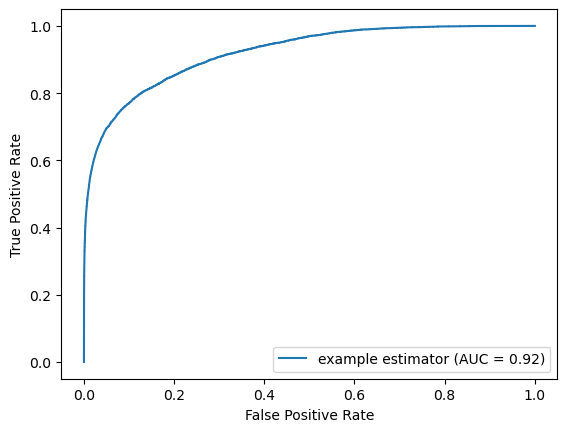

In [22]:
test_full_sets(coat_test_0.pe_present_on_image, coat_test_0.preds)

 0.9012528925315066 
 0.783419479071653 
 0.9786075379148106 
 0.4191746651483108 
 0.8914277988101676
[[97758 10711]
 [ 2137  7730]]


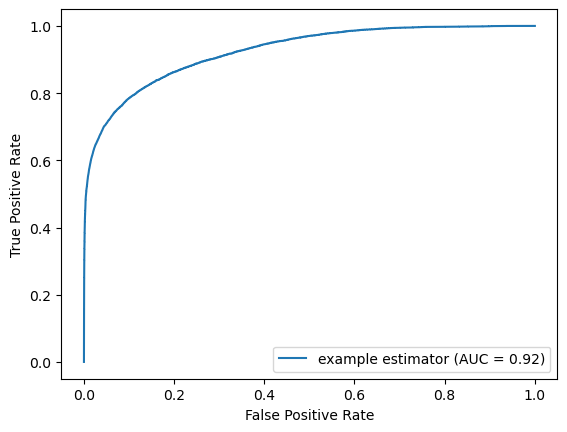

In [8]:
test_full_sets(turku_test_1.pe_in_slab, turku_test_1.preds)

 0.8996782550174701 
 0.7317790167257983 
 0.9736020352172395 
 0.3988177448759737 
 0.8856814494321255
[[97589 10882]
 [ 2646  7219]]


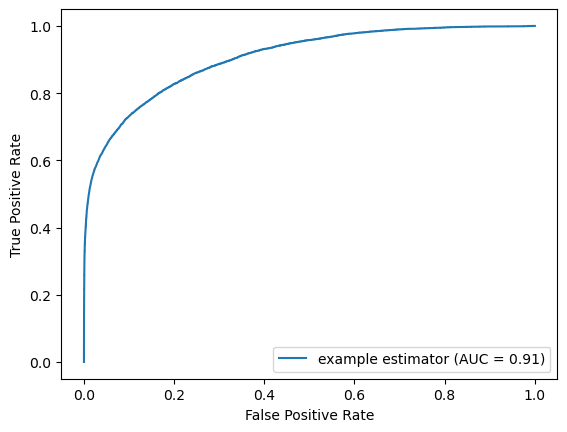

In [9]:
test_full_sets(coat_test_1.pe_present_on_image, coat_test_1.preds)

In [86]:
fold =0
model = get_model()
model.load_weights('/home/shared/model_checkpoint_paige/singlescan-3channel/coat-net-kfold_fold_0'+str(fold)+'.h5')

model = keras.models.Model(inputs=model.input, outputs=[model.layers[-3].output])
model.summary()

>>>> Load pretrained from: /home/jupyter-paige/.keras/models/coatnet0_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (256, 256)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb


<bound method Model.summary of <keras.engine.functional.Functional object at 0x7fbbce5b7760>>

In [88]:
# model_partial = keras.models.Sequential(model.layers[:-2])
model = keras.models.Model(inputs=model.input, outputs=[model.layers[-3].output])
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 coatnet0 (Functional)       (None, 512)               22930490  
                                                                 
 dropout_16 (Dropout)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 64)                32832     
                                                                 
Total params: 22,963,322
Trainable params: 22,951,674
Non-trainable params: 11,648
_________________________________________________________________


In [ ]:
unique_ids = all_ids_slab.StudyInstanceUID.unique()

IMG_TYPE = 0
IMAGE_PATH = '/home/shared/nps/imgs/'


for i in range(0,len(unique_ids)):
    exam_id = unique_ids[i]
    exam = all_ids_slab[all_ids_slab.StudyInstanceUID == exam_id]
    exam = exam.sort_values(by='ycoord')
    exam_generator = DataSlabGenerator(exam, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   n_channels=3, 
                                   set_type='test',
                                   batch_size=1,
                                   shuffle=False)
    
    x_test = np.zeros([len(exam),256,256,3])
    for j in range(0,len(exam)):
        x_test[j],_ = exam_generator.__getitem__(j)
   
    feats = np.zeros([len(exam),64])
    for j in range(int(len(exam)/64)):
        feats[j*64:(j+1)*64] = np.array(model(x_test[j*64:(j+1)*64]))
    if len(exam)%64 != 0:
        feats[(j+1)*64:] = np.array(model(x_test[(j+1)*64:]))
        
    exam['features'] = feats.tolist()
    
    np.save('/home/shared/nps/coat_fold_0/' + exam_id, exam.to_dict(orient='records'))
    if i %10 == 0:
        print(i, 'time is: ', datetime.datetime.now())
        gc.collect()

0 time is:  2022-10-31 18:59:48.635639
10 time is:  2022-10-31 19:00:42.365782
20 time is:  2022-10-31 19:01:31.956890
30 time is:  2022-10-31 19:02:20.490356
40 time is:  2022-10-31 19:03:08.091117
50 time is:  2022-10-31 19:03:53.757700
60 time is:  2022-10-31 19:04:40.985161
70 time is:  2022-10-31 19:05:31.536215
80 time is:  2022-10-31 19:06:20.350700
90 time is:  2022-10-31 19:07:10.173970
100 time is:  2022-10-31 19:07:51.660644
110 time is:  2022-10-31 19:08:35.850209
120 time is:  2022-10-31 19:09:24.277045
130 time is:  2022-10-31 19:10:14.071312
140 time is:  2022-10-31 19:10:58.065167
150 time is:  2022-10-31 19:11:43.202600
160 time is:  2022-10-31 19:12:27.511711
170 time is:  2022-10-31 19:13:13.649729
180 time is:  2022-10-31 19:14:02.200404
190 time is:  2022-10-31 19:14:43.732425
200 time is:  2022-10-31 19:15:25.778621
210 time is:  2022-10-31 19:16:08.076254
220 time is:  2022-10-31 19:16:51.653271
230 time is:  2022-10-31 19:17:33.598132


In [ ]:
fold =0
model = get_t()
model.load_weights('/home/shared/model_checkpoint_paige/singlescan-3channel/coat-net-kfold_fold_0'+str(fold)+'.h5')

model = keras.models.Model(inputs=model.input, outputs=[model.layers[-3].output])
model.summary()

In [103]:
unique_ids = all_ids_slab.StudyInstanceUID.unique()

IMG_TYPE = 0
IMAGE_PATH = '/home/shared/nps/imgs/'
BATCH_SIZE=1

# model = get_turku_model(1)
# model.load_weights('/home/shared/model_checkpoint_paige/singlescan-3channel/turku-incepres_fold_00.h5')
# model = keras.models.Model(inputs=model.input, outputs=[model.layers[-2].output])
# model.summary()

for i in range(0,len(unique_ids)):
    exam_id = unique_ids[i]
    exam = all_ids_slab[all_ids_slab.StudyInstanceUID == exam_id]
    exam = exam.sort_values(by='ycoord')
    exam_generator = DataSliceGenerator(exam, 
                                   IMAGE_PATH, 
                                   img_type = IMG_TYPE,
                                   verbose=False, 
                                   n_channels=1, 
                                   set_type='test',
                                   batch_size=1,
                                   shuffle=False)
    
    x_test = np.zeros([len(exam),386,386,1])
    for j in range(0,len(exam)):
        x_test[j],_ = exam_generator.__getitem__(j)
   
    feats = np.zeros([len(exam),64])
    for j in range(int(len(exam)/64)):
        feats[j*64:(j+1)*64] = np.array(model(x_test[j*64:(j+1)*64]))
    if len(exam)%64 != 0:
        feats[(j+1)*64:] = np.array(model(x_test[(j+1)*64:]))
        
    exam['features'] = feats.tolist()
    
    np.save('/home/shared/nps/turku_fold_0/' + exam_id, exam.to_dict(orient='records'))
    if i %10 == 0:
        print(i, 'time is: ', datetime.datetime.now())
        gc.collect()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 386, 386, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_812 (Conv2D)            (None, 192, 192, 32  288         ['input_27[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_812 (Batch  (None, 192, 192, 32  96         ['conv2d_812[0][0]']             
 Normalization)                 )                                                          

 conv2d_823 (Conv2D)            (None, 45, 45, 64)   12288       ['average_pooling2d_4[0][0]']    
                                                                                                  
 batch_normalization_817 (Batch  (None, 45, 45, 96)  288         ['conv2d_817[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_819 (Batch  (None, 45, 45, 64)  192         ['conv2d_819[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_822 (Batch  (None, 45, 45, 96)  288         ['conv2d_822[0][0]']             
 Normalization)                                                                                   
          

 Normalization)                                                                                   
                                                                                                  
 activation_833 (Activation)    (None, 45, 45, 32)   0           ['batch_normalization_833[0][0]']
                                                                                                  
 conv2d_831 (Conv2D)            (None, 45, 45, 32)   10240       ['block35_1_ac[0][0]']           
                                                                                                  
 conv2d_834 (Conv2D)            (None, 45, 45, 48)   13824       ['activation_833[0][0]']         
                                                                                                  
 batch_normalization_831 (Batch  (None, 45, 45, 32)  96          ['conv2d_831[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_841 (Batch  (None, 45, 45, 64)  192         ['conv2d_841[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_836 (Activation)    (None, 45, 45, 32)   0           ['batch_normalization_836[0][0]']
                                                                                                  
 activation_838 (Activation)    (None, 45, 45, 32)   0           ['batch_normalization_838[0][0]']
                                                                                                  
 activation_841 (Activation)    (None, 45, 45, 64)   0           ['batch_normalization_841[0][0]']
                                                                                                  
 block35_3_mixed (Concatenate)  (None, 45, 45, 128)  0           ['activation_836[0][0]',         
          

                                                                                                  
 batch_normalization_849 (Batch  (None, 45, 45, 32)  96          ['conv2d_849[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_852 (Batch  (None, 45, 45, 48)  144         ['conv2d_852[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_849 (Activation)    (None, 45, 45, 32)   0           ['batch_normalization_849[0][0]']
                                                                                                  
 activation_852 (Activation)    (None, 45, 45, 48)   0           ['batch_normalization_852[0][0]']
          

 activation_859 (Activation)    (None, 45, 45, 64)   0           ['batch_normalization_859[0][0]']
                                                                                                  
 block35_6_mixed (Concatenate)  (None, 45, 45, 128)  0           ['activation_854[0][0]',         
                                                                  'activation_856[0][0]',         
                                                                  'activation_859[0][0]']         
                                                                                                  
 block35_6_conv (Conv2D)        (None, 45, 45, 320)  41280       ['block35_6_mixed[0][0]']        
                                                                                                  
 block35_6 (Lambda)             (None, 45, 45, 320)  0           ['block35_5_ac[0][0]',           
                                                                  'block35_6_conv[0][0]']         
          

 activation_867 (Activation)    (None, 45, 45, 32)   0           ['batch_normalization_867[0][0]']
                                                                                                  
 activation_870 (Activation)    (None, 45, 45, 48)   0           ['batch_normalization_870[0][0]']
                                                                                                  
 conv2d_866 (Conv2D)            (None, 45, 45, 32)   10240       ['block35_7_ac[0][0]']           
                                                                                                  
 conv2d_868 (Conv2D)            (None, 45, 45, 32)   9216        ['activation_867[0][0]']         
                                                                                                  
 conv2d_871 (Conv2D)            (None, 45, 45, 64)   27648       ['activation_870[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 block35_9 (Lambda)             (None, 45, 45, 320)  0           ['block35_8_ac[0][0]',           
                                                                  'block35_9_conv[0][0]']         
                                                                                                  
 block35_9_ac (Activation)      (None, 45, 45, 320)  0           ['block35_9[0][0]']              
                                                                                                  
 conv2d_881 (Conv2D)            (None, 45, 45, 32)   10240       ['block35_9_ac[0][0]']           
                                                                                                  
 batch_normalization_881 (Batch  (None, 45, 45, 32)  96          ['conv2d_881[0][0]']             
 Normalization)                                                                                   
          

 activation_884 (Activation)    (None, 22, 22, 384)  0           ['batch_normalization_884[0][0]']
                                                                                                  
 activation_887 (Activation)    (None, 22, 22, 384)  0           ['batch_normalization_887[0][0]']
                                                                                                  
 max_pooling2d_18 (MaxPooling2D  (None, 22, 22, 320)  0          ['block35_10_ac[0][0]']          
 )                                                                                                
                                                                                                  
 mixed_6a (Concatenate)         (None, 22, 22, 1088  0           ['activation_884[0][0]',         
                                )                                 'activation_887[0][0]',         
                                                                  'max_pooling2d_18[0][0]']       
          

                                )                                                                 
                                                                                                  
 block17_2 (Lambda)             (None, 22, 22, 1088  0           ['block17_1_ac[0][0]',           
                                )                                 'block17_2_conv[0][0]']         
                                                                                                  
 block17_2_ac (Activation)      (None, 22, 22, 1088  0           ['block17_2[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_897 (Conv2D)            (None, 22, 22, 128)  139264      ['block17_2_ac[0][0]']           
                                                                                                  
 batch_nor

                                )                                 'block17_4_conv[0][0]']         
                                                                                                  
 block17_4_ac (Activation)      (None, 22, 22, 1088  0           ['block17_4[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_905 (Conv2D)            (None, 22, 22, 128)  139264      ['block17_4_ac[0][0]']           
                                                                                                  
 batch_normalization_905 (Batch  (None, 22, 22, 128)  384        ['conv2d_905[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                )                                                                 
                                                                                                  
 conv2d_913 (Conv2D)            (None, 22, 22, 128)  139264      ['block17_6_ac[0][0]']           
                                                                                                  
 batch_normalization_913 (Batch  (None, 22, 22, 128)  384        ['conv2d_913[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_913 (Activation)    (None, 22, 22, 128)  0           ['batch_normalization_913[0][0]']
                                                                                                  
 conv2d_914 (Conv2D)            (None, 22, 22, 160)  143360      ['activation_913[0][0]']         
          

                                                                                                  
 batch_normalization_921 (Batch  (None, 22, 22, 128)  384        ['conv2d_921[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_921 (Activation)    (None, 22, 22, 128)  0           ['batch_normalization_921[0][0]']
                                                                                                  
 conv2d_922 (Conv2D)            (None, 22, 22, 160)  143360      ['activation_921[0][0]']         
                                                                                                  
 batch_normalization_922 (Batch  (None, 22, 22, 160)  480        ['conv2d_922[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 activation_929 (Activation)    (None, 22, 22, 128)  0           ['batch_normalization_929[0][0]']
                                                                                                  
 conv2d_930 (Conv2D)            (None, 22, 22, 160)  143360      ['activation_929[0][0]']         
                                                                                                  
 batch_normalization_930 (Batch  (None, 22, 22, 160)  480        ['conv2d_930[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_930 (Activation)    (None, 22, 22, 160)  0           ['batch_normalization_930[0][0]']
                                                                                                  
 conv2d_92

 conv2d_938 (Conv2D)            (None, 22, 22, 160)  143360      ['activation_937[0][0]']         
                                                                                                  
 batch_normalization_938 (Batch  (None, 22, 22, 160)  480        ['conv2d_938[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_938 (Activation)    (None, 22, 22, 160)  0           ['batch_normalization_938[0][0]']
                                                                                                  
 conv2d_936 (Conv2D)            (None, 22, 22, 192)  208896      ['block17_12_ac[0][0]']          
                                                                                                  
 conv2d_939 (Conv2D)            (None, 22, 22, 192)  215040      ['activation_938[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_946 (Activation)    (None, 22, 22, 160)  0           ['batch_normalization_946[0][0]']
                                                                                                  
 conv2d_944 (Conv2D)            (None, 22, 22, 192)  208896      ['block17_14_ac[0][0]']          
                                                                                                  
 conv2d_947 (Conv2D)            (None, 22, 22, 192)  215040      ['activation_946[0][0]']         
                                                                                                  
 batch_normalization_944 (Batch  (None, 22, 22, 192)  576        ['conv2d_944[0][0]']             
 Normalization)                                                                                   
          

                                                                                                  
 conv2d_952 (Conv2D)            (None, 22, 22, 192)  208896      ['block17_16_ac[0][0]']          
                                                                                                  
 conv2d_955 (Conv2D)            (None, 22, 22, 192)  215040      ['activation_954[0][0]']         
                                                                                                  
 batch_normalization_952 (Batch  (None, 22, 22, 192)  576        ['conv2d_952[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_955 (Batch  (None, 22, 22, 192)  576        ['conv2d_955[0][0]']             
 Normalization)                                                                                   
          

 conv2d_963 (Conv2D)            (None, 22, 22, 192)  215040      ['activation_962[0][0]']         
                                                                                                  
 batch_normalization_960 (Batch  (None, 22, 22, 192)  576        ['conv2d_960[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_963 (Batch  (None, 22, 22, 192)  576        ['conv2d_963[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_960 (Activation)    (None, 22, 22, 192)  0           ['batch_normalization_960[0][0]']
                                                                                                  
 activatio

 batch_normalization_973 (Batch  (None, 22, 22, 288)  864        ['conv2d_973[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_968 (Activation)    (None, 22, 22, 256)  0           ['batch_normalization_968[0][0]']
                                                                                                  
 activation_970 (Activation)    (None, 22, 22, 256)  0           ['batch_normalization_970[0][0]']
                                                                                                  
 activation_973 (Activation)    (None, 22, 22, 288)  0           ['batch_normalization_973[0][0]']
                                                                                                  
 conv2d_969 (Conv2D)            (None, 10, 10, 384)  884736      ['activation_968[0][0]']         
          

 activation_980 (Activation)    (None, 10, 10, 192)  0           ['batch_normalization_980[0][0]']
                                                                                                  
 conv2d_981 (Conv2D)            (None, 10, 10, 224)  129024      ['activation_980[0][0]']         
                                                                                                  
 batch_normalization_981 (Batch  (None, 10, 10, 224)  672        ['conv2d_981[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_981 (Activation)    (None, 10, 10, 224)  0           ['batch_normalization_981[0][0]']
                                                                                                  
 conv2d_979 (Conv2D)            (None, 10, 10, 192)  399360      ['block8_1_ac[0][0]']            
          

                                                                                                  
 batch_normalization_989 (Batch  (None, 10, 10, 224)  672        ['conv2d_989[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_989 (Activation)    (None, 10, 10, 224)  0           ['batch_normalization_989[0][0]']
                                                                                                  
 conv2d_987 (Conv2D)            (None, 10, 10, 192)  399360      ['block8_3_ac[0][0]']            
                                                                                                  
 conv2d_990 (Conv2D)            (None, 10, 10, 256)  172032      ['activation_989[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 activation_997 (Activation)    (None, 10, 10, 224)  0           ['batch_normalization_997[0][0]']
                                                                                                  
 conv2d_995 (Conv2D)            (None, 10, 10, 192)  399360      ['block8_5_ac[0][0]']            
                                                                                                  
 conv2d_998 (Conv2D)            (None, 10, 10, 256)  172032      ['activation_997[0][0]']         
                                                                                                  
 batch_normalization_995 (Batch  (None, 10, 10, 192)  576        ['conv2d_995[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_nor

 hNormalization)                                                                                  
                                                                                                  
 activation_1005 (Activation)   (None, 10, 10, 224)  0           ['batch_normalization_1005[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_1003 (Conv2D)           (None, 10, 10, 192)  399360      ['block8_7_ac[0][0]']            
                                                                                                  
 conv2d_1006 (Conv2D)           (None, 10, 10, 256)  172032      ['activation_1005[0][0]']        
                                                                                                  
 batch_normalization_1003 (Batc  (None, 10, 10, 192)  576        ['conv2d_1003[0][0]']            
 hNormaliz

                                                                 ]                                
                                                                                                  
 conv2d_1013 (Conv2D)           (None, 10, 10, 224)  129024      ['activation_1012[0][0]']        
                                                                                                  
 batch_normalization_1013 (Batc  (None, 10, 10, 224)  672        ['conv2d_1013[0][0]']            
 hNormalization)                                                                                  
                                                                                                  
 activation_1013 (Activation)   (None, 10, 10, 224)  0           ['batch_normalization_1013[0][0]'
                                                                 ]                                
                                                                                                  
 conv2d_10

630 time is:  2022-11-01 10:40:57.464669
640 time is:  2022-11-01 10:41:39.096790
650 time is:  2022-11-01 10:42:25.032095
660 time is:  2022-11-01 10:43:14.576199
670 time is:  2022-11-01 10:44:03.282609
680 time is:  2022-11-01 10:44:48.335280
690 time is:  2022-11-01 10:45:36.673276
700 time is:  2022-11-01 10:46:19.361153
710 time is:  2022-11-01 10:46:59.234270
720 time is:  2022-11-01 10:47:45.966449
730 time is:  2022-11-01 10:48:26.602290
740 time is:  2022-11-01 10:49:15.153225
750 time is:  2022-11-01 10:50:01.827462
760 time is:  2022-11-01 10:50:45.725576
770 time is:  2022-11-01 10:51:30.704517
780 time is:  2022-11-01 10:52:09.145001
790 time is:  2022-11-01 10:52:59.549118
800 time is:  2022-11-01 10:53:45.948828
810 time is:  2022-11-01 10:54:36.447003
820 time is:  2022-11-01 10:55:20.413670
830 time is:  2022-11-01 10:56:07.179635
840 time is:  2022-11-01 10:56:51.530094
850 time is:  2022-11-01 10:57:35.503142
860 time is:  2022-11-01 10:58:20.306289
870 time is:  20

2590 time is:  2022-11-01 13:26:15.938988
2600 time is:  2022-11-01 13:27:19.515516
2610 time is:  2022-11-01 13:28:15.425111
2620 time is:  2022-11-01 13:29:05.811262
2630 time is:  2022-11-01 13:30:16.483382
2640 time is:  2022-11-01 13:31:15.767963
2650 time is:  2022-11-01 13:32:05.146046
2660 time is:  2022-11-01 13:32:53.551983
2670 time is:  2022-11-01 13:33:49.013238
2680 time is:  2022-11-01 13:34:40.149209
2690 time is:  2022-11-01 13:35:34.558432
2700 time is:  2022-11-01 13:36:31.371764
2710 time is:  2022-11-01 13:37:32.024564
2720 time is:  2022-11-01 13:38:34.986354
2730 time is:  2022-11-01 13:39:25.893479
2740 time is:  2022-11-01 13:40:24.938672
2750 time is:  2022-11-01 13:41:21.026744
2760 time is:  2022-11-01 13:42:17.783428
2770 time is:  2022-11-01 13:43:12.456151
2780 time is:  2022-11-01 13:44:12.365991


KeyboardInterrupt: 